<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/efficient_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the Bayesian notebook.  After working through this notebook you will be able to...
  * compute the entropy of a spike train

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as progressBar
import imageio as iio
from scipy import interpolate

Compute entropy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, '$-p\\log_{2}{p}-(1-p)\\log_{2}{1-p}$')

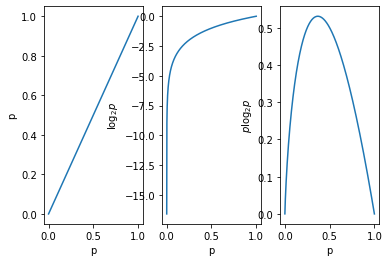

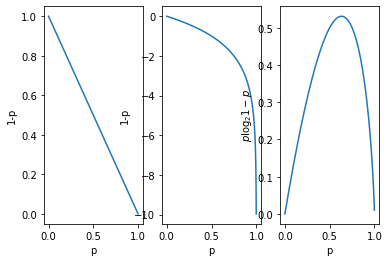

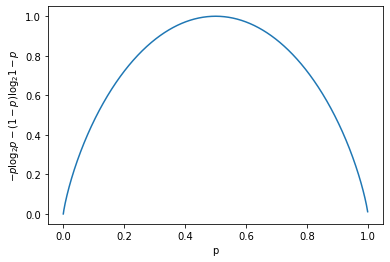

In [ ]:
p = np.linspace(0.00001,1,1000)

plt.subplot(1,3,1)
plt.plot(p,p)
plt.xlabel('p')
plt.ylabel('p')
plt.subplot(1,3,2)
plt.plot(p,np.log2(p))
plt.xlabel('p')
plt.ylabel('$\log_{2}{p}$')
plt.subplot(1,3,3)
plt.plot(p,-p*np.log2(p))
plt.xlabel('p')
plt.ylabel('$p\log_{2}{p}$')

plt.figure()
plt.subplot(1,3,1)
plt.plot(p,(1-p))
plt.xlabel('p')
plt.ylabel('1-p')
plt.subplot(1,3,2)
plt.plot(p,np.log2(1-p))
plt.xlabel('p')
plt.ylabel('1-p')
plt.subplot(1,3,3)
plt.plot(p,-(1-p)*np.log2(1-p))
plt.xlabel('p')
plt.ylabel('$p\log_{2}{1-p}$')

plt.figure()
plt.plot(p,-p*np.log2(p)-(1-p)*np.log2(1-p))
plt.xlabel('p')
plt.ylabel('Bits ($-p\log_{2}{p}-(1-p)\log_{2}{1-p}$)')

plt.savefig('entropy.pdf')

Following Barlow, we want to figure out how much information can be sent down a spiking fiber.

Two things need to be defined. 


1.   R, the number of discrete time intervals per second. If this number is 1, then we just compute the number of spikes in the fiber over 1 second. If it is 10, we do that ten times a second (so we can get information every 100ms). 
2.   I, the average number of spikes per second. Say 10 spikes/second. If the number is lower, then less information can be sent. If the number is higher more information can be sent.

Now, we could compute the number of spikes per interval as:

Average spikes per time interval: $\frac{I}{R}$

The assumption that Barlow is using is that this is a number less than 1 (which you can always guarantee by considering a larger number of discrete time intervals per second R). So, you can think about is as the probabiity that a spike will occur in one time interval (which we will call $p_{spike}$):

Eq 1: $p_{spike}$ = $\frac{I}{R}$

Now, let's compute the entropy of the channel. Remember that entropy is computed as

Eq 2: $H=-\sum_{i}p_{i}log_{2}{p_{i}}$

So, there are two states (i in the equation above) to consider. The state in which a spike occured and the state in which a spike did not occur. So the channel entropy per time interval is:

$H=-p_{spike} \log_{2}{p_{spike}} -p_{nospike} \log_{2}{p_{nospike}} $

Well, the probability of not having a spike is just 1-$p_{spike}$, so:

$H=-p_{spike} \log_{2}{p_{spike}} -(1-p_{spike}) \log_{2}{(1-p_{spike})} $

Ok. Now we just need to subsitute Eq 1, our definition for the probability of getting a spike into the equation above.

$H=-\frac{I}{R} \log_{2}{\frac{I}{R}} -(1-\frac{I}{R}) \log_{2}{(1-\frac{I}{R})} $

Now, Barlow computes this as a unit of time (i.e. how much entropy over a second), which you can just get by multiplying the above by the number of intervals per second R. He also multiplies by the number of fibers F. To get the expression in the paper for channel capacity C. 

$C=-FR[\frac{I}{R} \log_{2}{\frac{I}{R}} +(1-\frac{I}{R}) \log_{2}{(1-\frac{I}{R})}]$

Let's consider the number of time intervals R to be 10, and the number of fibers to be 1, and compute the channel capacity as a function of average spikes per second







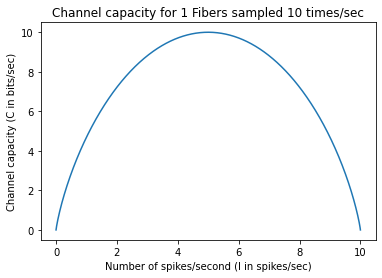

In [108]:
# number of fibers
F = 1
# numbers of sampling periods per second
R = 10
# max firing rate of a single fiber
maxI = 10
# small number to avoid log warnings 
epislon = 0.0001

# compute for various spikes/second up to maximum firing rate
I = np.linspace(epsilon,maxI-epsilon,1000)

# compute channel capacity
C = -F * R * ((I/R)*np.log2(I/R) + (1-I/R)*np.log2(1-I/R))

# plot
plt.plot(I,C)
plt.ylabel('Channel capacity (C in bits/sec)')
plt.xlabel('Number of spikes/second (I in spikes/sec)')
plt.title('Channel capacity for %i Fibers sampled %i times/sec'%(F,R));


Let's compute the mutual information between a neuron firing and a stimulus. 

Mutual information can be thought of as how much you reduce the stimulus entropy by knowing the firing of the neuron (and, implicitly, assuming that you know how the firing relates to the stimulus). I know, it's all a bit confusing because of the negatives in that statement. Would it be easier to say that it is how much you have increased your certainty about the stimulus by knowing the neurons firing?

That is, no mutual information means that the firing rate tells you nothing about the stimulus (you don't reduce the uncertainty at all). The higher the mutual information, the more the firing rate tells you about the stimulus, with the maximum amount possible being how much information (entropy) is in the stimulus itself. 

Let's use an example to make this a little easier to digest. Say the stimulus is a light which can either be on or off (in state 0 or state 1). The neuron can fire either one spike or 0 spikes. 

The formal definition of mutual information is:

$I(stimulus;spike) = \sum_{stimulus}\sum_{spike}p(stimulus,spike)\log_2\frac{p(stimulus,spike)}{p(spike)p(stimulus)}$

Where:
*   $I(stimulus;spike)$ is the mutual information between stimulus and spikes.
* The summations go over all stimulus values (in our case 0 and 1 for light off and light on) and all spike values (in our case 0 for no spike and 1 for spike)
*   $p(stimulus,spike)$ is the probability of combinations of stimulus and spike specified by the input arguments. Be carefual about what this means. Here it means that if e.g. $p(1,1)$, then this is the probability of the combined event: light on and a spike. If $p(0,1)$ then this is the probabilty of the combined evenet: light off and having a spike and so on. In our case 4 possibilities. 
*  $p(stimulus)$ is the probabily of the light being on or off (i.e. $p(1)$ = probability of light on and $p(0)$ = probability of light off).
*  $p(spike)$ is the probabily of having a spike or not (i.e. $p(1)$ = probability of seeing a spike and $p(0)$ = probability of not seeing a spike).

It turns out (check [wikipedia](https://en.wikipedia.org/wiki/Mutual_information) for derivation from the above expression) that another - slightly more intuitive - expression for mutual information is:

$I(stimulus;spike) = H(stimulus) - H(stimulus | spike)$

Where:
* $H(stimulus)$ is the entropy of the stimulus
* $H(stimulus | spike)$ is the conditional entropy, i.e. the entropy of the stimulus, given the spikes. Note that this value can be considered the entropy of what is **left over** in the stimulus given you know the spikes. That is, if the spikes tell you everything about the stimulus, there would be no left over entropy to describe, so this number would be 0. If the spikes tell you nothing about the stimulus, then this number would be equal to the entropy of the stimulus. 

From that, you should get the itutitive description of mutual information. After knowing the spikes, it is how much you have reduced the uncertainty about the stimulus. 

Ok, let's get specific to test our understanding. If the neurons spiking is completeley unrelated to the stimulus, then knowing the spiking would not reduce the stimulus entropy, so your mutual information would be 0. If the neuron firing followed one-to-one with the light (i.e. spiked when the light was on, and did not spike when the light was off), then knowing the spike, would give you exact information about the light, so there would be no more stimulus entropy, and thus the entropy would be reduced the maximum amount (which in this case is 1 bit because the light could be either on or off) and therefore the mutual information would be 1 bit. 

Still confused? Use the code below to test your intuitions. It computes mutual information with both formulas (just so that you can be sure you understand what each formula means). You can adjust the stimulus probability (i.e. whether the light will be on or off using the value **pstim**. If pstim is 1, then the light is always on. If pstim is 0 then light is always off. What value of pstim gives you the highest entropy (you should know that from above!!). The value **pstimspike** species how much the spikes follow the stimulus. If 1, then there is a spike everytime the light is on. If you set to 0.5 there will be a random relationship between stimulus and spike.

In [96]:
# probability that the stimulus light will be on
pstim = 0.5

# now we make the conditional probability. 
# there are two states of the world, one
# in which the light is on, and this
# probabilty governs whether a spike will
# be generated or not. Note that 1 is always
# spike when the light is on and 0 is always
# spike when the light is off. To make
# for a spike that is unrelated to the stimulus
# set to 0.5
pstimspike = 1

# first we deal with the fact that the formulas fail
# for when p = 0 or p = 1, so we just add a little
# epsilon to avoid these values
epsilon = 0.00001
if pstim < epsilon: pstim=epsilon
if pstimspike < epsilon: pstimspike=epsilon
if pstim > (1-epsilon): pstim=1-epsilon
if pstimspike > (1-epsilon): pstimspike=(1-epsilon)

# there is also the state with no light 
# and this governs how often a spike
# will be generated in that case,
# we just assume this is 1-pstimspike
# for simplicity (though it could take on
# it's own independent value)
pnostimspike = (1-pstimspike)

# let's compute the stimulus entropy
Hstim = - pstim * np.log2(pstim) - (1-pstim) *np.log2(1-pstim)

# now we find the joint probability of each
# possible pair of possibilities of stimulus on/off
# and spike fired/not fired. This is used for the
# formal calculation of Mutual Information.
pstim_and_spike = pstim * pstimspike
pstim_and_nospike = pstim * (1-pstimspike)
pnostim_and_spike = (1-pstim) * pnostimspike
pnostim_and_nospike = (1-pstim) * (1-pnostimspike)

# calculate the overall probability of a spike
pspike = pstim_and_spike + pnostim_and_spike

# Ok, now let's compute mutual information using the formula. We
# do each sum as a separate line (4 in all for all combinations
# of stimulus and spike.)
I = pstim_and_spike * np.log2(pstim_and_spike/(pstim*pspike))
I += pstim_and_nospike * np.log2(pstim_and_nospike/(pstim*(1-pspike)))
I += pnostim_and_spike * np.log2(pnostim_and_spike/((1-pstim)*pspike))
I += pnostim_and_nospike * np.log2(pnostim_and_nospike/((1-pstim)*(1-pspike)))

# We can also compute infomration using the alternate expression
# as the stimulus entropy minus the stimulus entropy conditioned
# on the spike. SO, let's compute the conditional entropy needed;
Hstimspike = - pstim_and_spike * np.log2(pstim_and_spike/pspike)
Hstimspike -= pstim_and_nospike * np.log2(pstim_and_nospike/(1-pspike))
Hstimspike -= pnostim_and_spike * np.log2(pnostim_and_spike/pspike)
Hstimspike -= pnostim_and_nospike * np.log2(pnostim_and_nospike/(1-pspike))

# let's compute the mutual information with the alternate formulation
M = Hstim - Hstimspike

# print some of the intermediate calculations so that you can see what is going on step by step.
#print('Probabiity of stimulus and spike %0.2f (pspike: %0.2f pxy/px: %0.2f log2(pxy/px): %0.2f, H1: %0.2f)'%(pstim_and_spike,pspike,pstim_and_spike/pspike,np.log2(pstim_and_spike/pspike),pstim_and_spike*np.log2(pstim_and_spike/pspike)))
#print('Probabiity of stimulus and no spike %0.2f (pnospike: %0.2f pxy/px: %0.2f log2(pxy/px): %0.2f, H2: %0.2f)'%(pstim_and_spike,(1-pspike),pstim_and_spike/(1-pspike),np.log2(pstim_and_spike/(1-pspike)),pstim_and_spike*np.log2(pstim_and_spike/(1-pspike))))
#print('Probabiity of no stimulus and spike %0.2f (pspike: %0.2f pxy/px: %0.2f log2(pxy/px): %0.2f, H2: %0.2f)'%(pnostim_and_spike,pspike,pnostim_and_spike/pspike,np.log2(pnostim_and_spike/pspike),pnostim_and_spike*np.log2(pnostim_and_spike/pspike)))
#print('Probabiity of no stimulus and spike %0.2f (pspike: %0.2f pxy/px: %0.2f log2(pxy/px): %0.2f, H4: %0.2f)'%(pnostim_and_nospike,(1-pspike),pnostim_and_nospike/(1-pspike),np.log2(pnostim_and_nospike/(1-pspike)),pnostim_and_nospike*np.log2(pnostim_and_nospike/(1-pspike))))

# Display outcome of the calculations
print('Stimulus entropy: %0.2f Stimulus entropy conditioned on spike: %0.2f Mutual Information: %0.2f'%(Hstim,Hstimspike,I))

Stimulus entropy: 1.00 Stimulus entropy conditioned on spike: 0.00 Mutual Information: 1.00


Let's do some image statistics.

First let's grab some code from the [Frequency Freaks](https://colab.research.google.com/drive/1Yxj-Cld8uV3uNQ28WNcgH0udZVqJbdgy#scrollTo=9MNK0CyzLFwN) notebook.

In [2]:
def getMeshPoints(nPoints):

  # first create a linearly spaced set of x and y points between -1 and 1
  x = np.linspace(-1,1,nPoints)
  y = np.linspace(-1,1,nPoints)

  # keep the extents for use with imshow
  extents = [np.min(x),np.max(x),np.min(y),np.max(y)]

  # now create the mesh of x and y (these will now both be 2D matrices of x and y values)
  x, y = np.meshgrid(x, y, indexing='xy')

  # and return the computed values
  return x, y, extents

def getImage(filename,imageSize):
  # first load the image
  img = iio.imread(filename)

  # make graycale by averaging across color dimensions
  img = img.mean(2)

  # get a square of the image
  imgSquareSize = np.min(img.shape);
  img =img[0:imgSquareSize,0:imgSquareSize]

  # interpolate to preferred size 
  fun = interpolate.interp2d(np.linspace(0,1,imgSquareSize),np.linspace(0,1,imgSquareSize),img,kind='linear')
  img = fun(np.linspace(0,1,imageSize),np.linspace(0,1,imageSize))

  # normalize values to between -1 and 1
  # just because this is a typical and easy way to 
  # think about values of an image 0 is gray -1 is black and 1 is white
  # just like for a sinewave grating!
  img = (img - img.min())/(img.max() - img.min())
  img = 2 * img - 1

  # return the image
  return img 

Now, let's write a function that will compute the fourier spectrum of the image and then plot the amplitude as a function of spatial frequency (averaging over orientation and the amplitude as a function of orientation (averaging over spatial frequency)

In [97]:
def computeSpectrum(img):
  # compute size of image
  imgSize = np.shape(img)[0]
  halfSize = int(np.floor(imgSize/2))
  # remove mean (so that we don't get a big DC component)
  img -= np.mean(img)
  # now compute fourier transform
  imgFFT = np.abs(np.fft.fftshift(np.fft.fft2(img)))
  # now make an x,y grid of points to cover the FFT
  x,y,extents = getMeshPoints(imgSize)
  # amd convert them to radial coordinates
  r = np.sqrt(x**2+y**2)
  theta = np.arctan2(y,x)
  # now normalize r so that it is in cycles/image
  # the farthest component with value 1 is the highest spatial frequency
  # which for the image is floor(imgSize/2)
  r = r * halfSize
  # now for each radius bin, calculate the summed amplitude
  sfSpectrum, sfBins = np.histogram(r,bins=halfSize,weights=imgFFT)
  # and the number of components contributing to each bin
  nSFComponents, sfBins = np.histogram(r,bins=halfSize)
  # and now get the average amplitude by dividing by the num of components
  sfSpectrum /= nSFComponents
  # divide by two, to account for the symmetry of the Fourier domain
  sfSpectrum /= 2
  # get the center of each bin
  sfBins = (sfBins[0:-1] + sfBins[1:])/2

  # now for each orientation bin, calculate the summed amplitude
  orientSpectrum, orientBins = np.histogram(theta,bins=360,weights=imgFFT)
  # and the number of components contributing to each bin
  nOrientComponents, orientBins = np.histogram(theta,bins=360)
  # and now get the average amplitude by dividing by the num of components
  orientSpectrum /= nOrientComponents
  # return only half (since the other thalf is just a mirror-image)
  orientSpectrum = orientSpectrum[0:179]
  orientBins = -180*orientBins[0:179]/np.pi
  
  # return
  return sfSpectrum, sfBins, orientSpectrum, orientBins

In [54]:
# load an image
imageSize = 3
img = getImage('iceland.png',imageSize)


([<matplotlib.axis.XTick at 0x7f0cfa57db90>,
 <a list of 5 Text major ticklabel objects>)

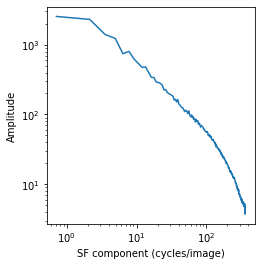

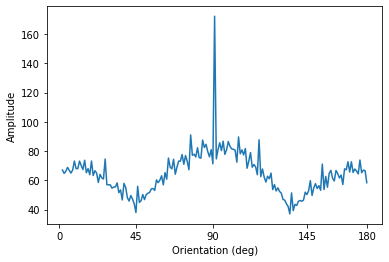

In [103]:
# compute sf and orientation spectrum
sfSpectrum, sfBins, orientSpectrum, orientBins = computeSpectrum(img)

# plot spectrum
plt.loglog(sfBins,sfSpectrum)
plt.xlabel('SF component (cycles/image)')
plt.ylabel('Amplitude')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.figure()
plt.xlabel('Orientation (deg)')
plt.ylabel('Amplitude')
plt.plot(orientBins, orientSpectrum)
plt.xticks((0,45,90,145,180))

In [106]:
img -= np.mean(img)
np.mean(img)

2.1599587664507602e-19